# Introduction
Beta Bank customers are leaving: little by little, chipping away every month.  The bankers figured out that it's cheaper to save the existing customers rather than to attract new ones.  In this project, we will use customer churn data to develop a machine learning model to predict whether a customer will leave the bank soon.

First, we will review the data to gain a general familiarity and to identify preprocessing requirements. During the preprocessing phase, we will fill missing values, eliminate unnecessary columns, prepare the data for machine learning, and split the data into subsets for model development and testing. Next, we will build several machine learning models, with the goal achieving an _f1_ score of at least 0.59.  Our initial model will retain the class imbalance in the data.  Then, we will remedy the class imbalance in an effort to improve the model.

# Preliminary data review

In [1]:
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, \
                            f1_score, classification_report, roc_curve, auc
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings

In [2]:
warnings.filterwarnings('ignore')

random_state = 12345
scoring = 'f1'

try:
    df = pd.read_csv('Churn.csv')
except:
    df = pd.read_csv('/datasets/Churn.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


There are 909 missing values for <code>Tenure</code>.  Several columns can be eliminated because they will not contribute to a predictive model.  Data types seem appropriate, but <code>Geography</code> and <code>Gender</code> will need to be converted to dummy variables.

In [4]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


## Missing data: <code>Tenure</code>

In [5]:
df[df['Tenure'].isnull()].head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
30,31,15589475,Azikiwe,591,Spain,Female,39,NaN,0.00,3,1,0,140469.38,1
48,49,15766205,Yin,550,Germany,Male,38,NaN,103391.38,1,0,1,90878.13,0
51,52,15768193,Trevisani,585,Germany,Male,36,NaN,146050.97,2,0,0,86424.57,0
53,54,15702298,Parkhill,655,Germany,Male,41,NaN,125561.97,1,0,0,164040.94,1
60,61,15651280,Hunter,742,Germany,Male,35,NaN,136857.00,1,0,0,84509.57,0


In rows with missing <code>Tenure</code>, the other columns seem to be correct.

In [6]:
df[df['Tenure'] == 0.0].head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
29,30,15656300,Lucciano,411,France,Male,29,0.0,59697.17,2,1,1,53483.21,0
35,36,15794171,Lombardo,475,France,Female,45,0.0,134264.04,1,1,0,27822.99,1
57,58,15647091,Endrizzi,725,Germany,Male,19,0.0,75888.20,1,0,0,45613.75,0
72,73,15812518,Palermo,657,Spain,Female,37,0.0,163607.18,1,0,1,44203.55,0
127,128,15782688,Piccio,625,Germany,Male,56,0.0,148507.24,1,1,0,46824.08,1


A <code>Tenure</code> of 0.0 is not the same as a missing <code>Tenure</code>.

In [7]:
pd.DataFrame(df.corr()['Tenure']).sort_values(by='Tenure',ascending=False).style.background_gradient(cmap='twilight')

,Tenure
Tenure,1.000000
HasCrCard,0.027232
NumOfProducts,0.011979
EstimatedSalary,0.010520
CreditScore,-0.000062
RowNumber,-0.007322
Balance,-0.007911
Age,-0.013134
Exited,-0.016761
CustomerId,-0.021418


<code>Tenure</code> is not strongly correlated with any other variable.

## Class distribution

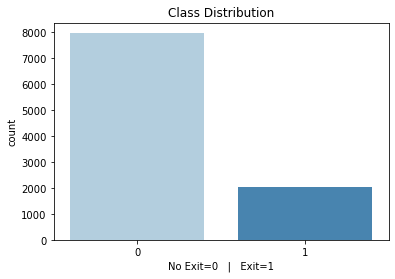

In [8]:
labels ='No Exit=0   |   ' + 'Exit=1'
sns.countplot(x=df['Exited'], palette='Blues')
plt.title('Class Distribution')
plt.xlabel(labels);

There is significant class imbalance.  There are about 4 times as many customers who didn't leave the bank.

## Conclusion
- There are 909 missing values for <code>Tenure</code>, representing 9% of the data.  There are other rows with a <code>Tenure</code> of 0.0, so the missing values probably do not mean 0.0.  <code>Tenure</code> is not strongly correlated with other variables.  These values seem to be missing at random.  We will fill the missing <code>Tenure</code> values with the mean.
- Several columns do not have predictive value with respect to customer churn:  <code>RowNumber</code>, <code>CustomerId</code>, and <code>Surname</code>.  These will be dropped from the dataset.
- Two columns represent categorical variables but are currently strings:  <code>Geography</code> and <code>Gender</code>.  These will be converted to dummy variables.
- <code>NumOfProducts</code> is ordinal and does not require conversion.  <code>HasCrCard</code> and <code>IsActiveMember</code> are already ready to go as indicator variables.
- The numerical variables have very different magnitudes and standard deviations.  Some models, such as logistic regression, would require scaling/standardization of features.  However, we will be using a random forest model, which can handle varying ranges of features and does not require feature scaling.
- There is significant imbalance between the two target classes.  We will develop a model that retains this class imbalance and then address the imbalance to improve the model.

# Preprocessing

## Fill missing values
As discussed above, we will fill missing <code>Tenure</code> values with the mean.

In [9]:
df.loc[df['Tenure'].isna(), 'Tenure'] = df['Tenure'].mean(skipna=True)

## Drop unnecessary columns
<code>RowNumber</code>, <code>CustomerId</code>, <code>Surname</code> are unlikely to predict whether a customer is likely to leave the bank soon, so we will drop these columns from the data set.

In [10]:
df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1, inplace=True)
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


## Feature preparation

### Encoding of categorical variables
Our data includes two categorical columns with <code>object (string)</code> type: <code>Geography</code> and <code>Gender</code>.  These will be converted to dummy variables.

In [11]:
df = pd.get_dummies(df, drop_first=True)
df.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,0,1,0


### Scaling of numeric variables
The random forest classifier that we will be using does not benefit from scaling of features.

In [12]:
#scaler = StandardScaler()
#numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
#scaler.fit(df[numeric])
#df[numeric] = scaler.transform(df[numeric])
#df.head()

## Training and test datasets

We will not create a separate validation set because we will be using <code>GridSearchCV</code>, which performs k-fold cross validation.  This saves us from the need for a separate validation set and allows us to use more of our data for model development. 

In [13]:
X = df.drop(columns=['Exited']).copy()
y = df['Exited']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=random_state)

print('Training features shape {} rows, {} columns\n           target shape {} columns\n'.format(
    X_train.shape[0], 
    X_train.shape[1], 
    y_train.shape[0]))
print('Test features shape {} rows, {} columns\n       target shape {} columns\n'.format(
    X_test.shape[0], 
    X_test.shape[1], 
    y_test.shape[0]))

Training features shape 7500 rows, 11 columns
           target shape 7500 columns

Test features shape 2500 rows, 11 columns
       target shape 2500 columns



## Model evaluation function
<code>evaluate_model()</code> fits the model on the training set and evaluates the model on the test set.  It prints a performance report including _accuracy_, _recall_, and _f1_ scores, as well as a classification report, confusion matrix, and ROC curve.

In [14]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    # Fit model on training set
    fit_model = model.fit(X_train, y_train)

    # Predict on test, training data
    y_hat_test = fit_model.predict(X_test)
    y_hat_train = fit_model.predict(X_train)

    # Accuracy, precision, and recall scores
    print("\nTraining data")
    print('-' * 13)
    print(f"Accuracy: {accuracy_score(y_train, y_hat_train)}")
    print(f"Precision: {precision_score(y_train, y_hat_train)}")
    print(f"Recall: {recall_score(y_train, y_hat_train)}")
    print(f"f1: {f1_score(y_train, y_hat_train)}")
    print("\nTest data")
    print('-' * 9)
    print(f"Accuracy: {accuracy_score(y_test, y_hat_test)}")
    print(f"Precision: {precision_score(y_test, y_hat_test)}")
    print(f"Recall: {recall_score(y_test, y_hat_test)}")
    print(f"f1: {f1_score(y_test, y_hat_test)}")
    
    # Classification report
    print("\nClassification Report")
    print('-' * 21)
    print(classification_report(y_test, y_hat_test))
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_hat_test)
    ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    # ROC curve on second ax
    probs = model.predict_proba(X_test)
    preds = probs[:,1]
    fpr, tpr, threshold = roc_curve(y_test, preds)
    roc_auc = auc(fpr, tpr)
    plt.title('ROC')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

## Conclusion
In this section, we filled missing values for <code>Tenure</code>, dropped several unnecessary columns, and encoded <code>Geography</code> and <code>Gender</code> as indicator variables.  We split our data into training and test sets, and we defined a function that will be used to evaluate our models.

# Model development
In this section, we will develop models to predict whether a customer will leave the bank soon.  We will be using the <code>RandomForestClassifier</code>.  Earlier, we identified significant class imbalance for our target.  Our initial model will retain this class imbalance.  Then, we will improve upon the initial model by eliminating the class imbalance, first by class weight adjustment and then by upsampling.

## Imbalanced classes

### Hyperparameter selection

In [15]:
params = {'n_estimators': range(50, 300, 50), 
          'max_depth': range(10, 24, 2), 
          'class_weight': [None]
         }

# Best
params = {'n_estimators': [200], 
          'max_depth': [20], 
          'class_weight': [None]
         }

In [16]:
forest = RandomForestClassifier(random_state=random_state)
clf = GridSearchCV(estimator=forest, param_grid=params, scoring=scoring, cv=10, verbose=0)
clf.fit(X_train, y_train)
best_params = clf.best_params_
best_params

{'class_weight': None, 'max_depth': 20, 'n_estimators': 200}

In [17]:
best_forest = RandomForestClassifier(**best_params, random_state=random_state)
best_forest.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 20,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 200,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 12345,
 'verbose': 0,
 'warm_start': False}

### Model evaluation


Training data
-------------
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
f1: 1.0

Test data
---------
Accuracy: 0.8532
Precision: 0.7745098039215687
Recall: 0.44299065420560746
f1: 0.563614744351962

Classification Report
---------------------
              precision    recall  f1-score   support

           0       0.86      0.96      0.91      1965
           1       0.77      0.44      0.56       535

    accuracy                           0.85      2500
   macro avg       0.82      0.70      0.74      2500
weighted avg       0.84      0.85      0.84      2500



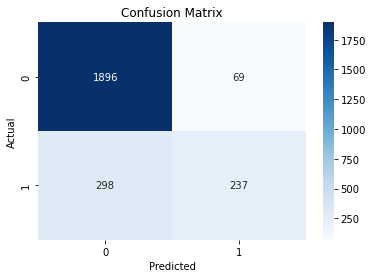

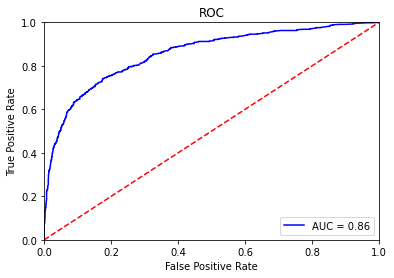

In [18]:
evaluate_model(best_forest, X_train, y_train, X_test, y_test)

Our intial model did not do a very good job of identifying the minority class, i.e., customers who left the bank.  This resulted in low _recall_ and _f1_ scores.

## Balanced classes
In this section, we attempt to improve on the initial model by compensating for imbalance in the target class.  The idea is to incentivize selection of the minority class, thereby improving the _recall_ and _f1_ scores.

### Class weight adjustment
First, we will address class imbalance by specifying <code>class_weight=balanced</code>.  This will produce inverse frequency weighting.

#### Hyperparameter selection

In [19]:
params = {'n_estimators': range(450, 650, 50), 
          'max_depth': range(4, 14, 2), 
          'class_weight': ['balanced']
         }

# Best
params = {'n_estimators': [500], 
          'max_depth': [10], 
          'class_weight': ['balanced']
         }

In [20]:
forest = RandomForestClassifier(random_state=random_state)
clf = GridSearchCV(estimator=forest, param_grid=params, scoring=scoring, cv=10, verbose=0)
clf.fit(X_train, y_train)
best_params = clf.best_params_
best_params

{'class_weight': 'balanced', 'max_depth': 10, 'n_estimators': 500}

In [21]:
best_forest = RandomForestClassifier(**best_params, random_state=random_state)
best_forest.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': 10,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 500,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 12345,
 'verbose': 0,
 'warm_start': False}

#### Model evaluation


Training data
-------------
Accuracy: 0.912
Precision: 0.7560827250608273
Recall: 0.8275632490013316
f1: 0.7902097902097903

Test data
---------
Accuracy: 0.8432
Precision: 0.627906976744186
Recall: 0.6560747663551402
f1: 0.6416819012797074

Classification Report
---------------------
              precision    recall  f1-score   support

           0       0.91      0.89      0.90      1965
           1       0.63      0.66      0.64       535

    accuracy                           0.84      2500
   macro avg       0.77      0.78      0.77      2500
weighted avg       0.85      0.84      0.84      2500



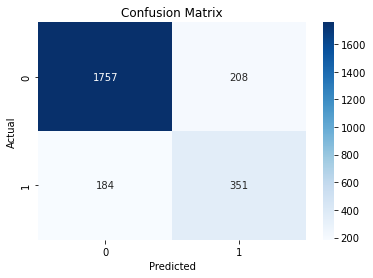

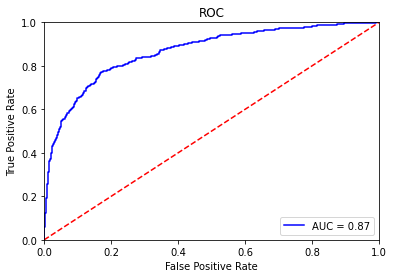

In [22]:
evaluate_model(best_forest, X_train, y_train, X_test, y_test)

As expected, class weight adjustment improved our model's ability to identify the minority class and increased our _recall_ and _f1_ scores.

### Upsampling
Now we will try another method to address class imbalance:  upsampling.  This method involves randomly selecting members of the minority class and shuffling them into our training data.  We will upsample such that we have the same number of customers in both target classes.

In [23]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)

    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=random_state
    )

    return features_upsampled, target_upsampled

repeat = int(round(len(y_train[y_train == 0])/len(y_train[y_train == 1])))
X_upsampled, y_upsampled = upsample(X_train, y_train, repeat)
repeat

4

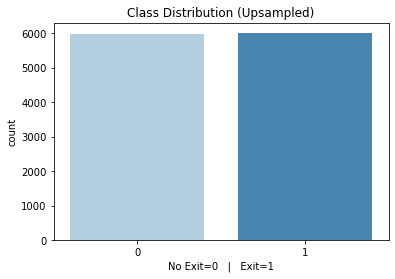

In [24]:
labels ='No Exit=0   |   ' + 'Exit=1'
sns.countplot(x=y_upsampled, palette='Blues')
plt.title('Class Distribution (Upsampled)')
plt.xlabel(labels);

#### Hyperparameter selection

In [25]:
params = {'n_estimators': [350], 
          'max_depth': range(18, 32, 2), 
          'class_weight': [None]
         }

# Best
params = {'n_estimators': [350], 
          'max_depth': [20], 
          'class_weight': [None]
         }

In [26]:
forest = RandomForestClassifier(random_state=random_state)
clf = GridSearchCV(estimator=forest, param_grid=params, scoring=scoring, cv=10, verbose=0)
clf.fit(X_upsampled, y_upsampled)
best_params = clf.best_params_
best_params

{'class_weight': None, 'max_depth': 20, 'n_estimators': 350}

In [27]:
best_forest = RandomForestClassifier(**best_params, random_state=random_state)
best_forest.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 20,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 350,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 12345,
 'verbose': 0,
 'warm_start': False}

#### Model evaluation


Training data
-------------
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
f1: 1.0

Test data
---------
Accuracy: 0.8504
Precision: 0.6842105263157895
Recall: 0.5588785046728972
f1: 0.6152263374485597

Classification Report
---------------------
              precision    recall  f1-score   support

           0       0.89      0.93      0.91      1965
           1       0.68      0.56      0.62       535

    accuracy                           0.85      2500
   macro avg       0.78      0.74      0.76      2500
weighted avg       0.84      0.85      0.84      2500



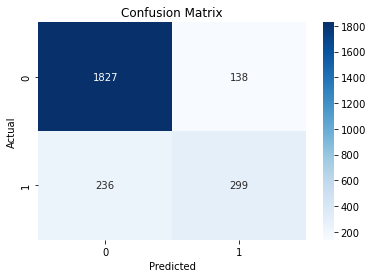

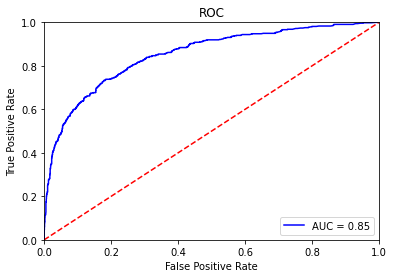

In [28]:
evaluate_model(best_forest, X_upsampled, y_upsampled, X_test, y_test)

As with class weight adjustment, upsampling improved upon the _recall_ and _f1_ scores of our initial model.  Of the two methods for addressing target class imbalance, class weight adjustment produced slightly better results.

## Conclusion
In this section, we used the <code>RandomForestClassifer</code> to develop a model to predict whether a client will leave the bank soon.  We used <code>GridSearchCV</code> to select a good set of hyperparameters.  Our intial model, which retained the target class imbalance, failed to achieve our minimum target _f1_ score of 0.59.  However, when the imbalance was addressed through class weight adjustment or upsampling, our models exceeded the target.

Our best model, which used class weight adjustment, had an _f1_ of __0.64__ and an _AUC_ of __0.87__.  This _AUC_ score means that when given one randomly selected positive instance and one randomly selected negative instance, our classifier has a 87% chance of telling which one is which.

# Conclusion
Managers at the Beta Bank have identified a need to improve customer retention.  Using data on customer churn, we developed a machine learning classifer that can identify customers who are likely to leave soon.  Using the model, bank managers will know where to focus their customer retention efforts.